<a href="https://colab.research.google.com/github/Sidharth-Darwin/PyTorch_Programs/blob/main/FreshOrRottenApple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem
A simple CNN model that can classify whether the input image of apple has is fresh or rotten.

In [1]:
from google.colab import drive
import os
import shutil
import json
import glob
from PIL import Image
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchsummary import summary
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, \
    RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from torchvision.transforms.functional import pad

In [3]:
d_or_c_option = "d"
d_or_c_name = "srishtisharma9977/fresh-apple-vs-rotten-apple-classification"

os.system("pip install kaggle")

kaggle_key_path = "/content/drive/MyDrive/Kaggle API Key/kaggle.json"
kaggle_key_dest = "/.kaggle"
dataset_path = "/content/data/"

if os.path.exists(dataset_path) is False:
  if d_or_c_option:
    d_or_c = d_or_c_option
  else:
    d_or_c = str.lower(input("Enter D for dataset or C for competition: "))
  if (d_or_c == 'd'):
    if d_or_c_name:
      d_name = d_or_c_name
    else:
      d_name = input("Enter the name of dataset in 'owner/dataset' format: ")
  elif (d_or_c == 'c'):
    if d_or_c_name:
      c_name = d_or_c_name
    else:
      c_name = input("Enter the name of competition in 'owner/competition' format: ")
  else:
    print("Enter valid option!")

if os.path.exists("/content/drive") is False:
  drive.mount('/content/drive')
  print("Drive is ready to use!")
else:
  print("Drive is already ready to use!")

if os.path.exists(os.path.join(kaggle_key_dest, "kaggle.json")) is False:
  os.mkdir(kaggle_key_dest)
  shutil.copy(kaggle_key_path, kaggle_key_dest)
  os.chmod(os.path.join(kaggle_key_dest, "kaggle.json"), 600)
  print("Kaggle api key is ready to use!")
else:
  print("Kaggle api key is already ready to use!")

if os.path.exists(dataset_path) is False:
  with open(os.path.join(kaggle_key_dest, "kaggle.json"), "r") as f:
    data = json.load(f)
  os.environ["KAGGLE_USERNAME"] = data["username"]
  os.environ["KAGGLE_KEY"] = data["key"]
  del data

  import kaggle

  kaggle.api.authenticate()
  if (d_or_c == 'd'):
    kaggle.api.dataset_download_files(
      d_name,
      path=dataset_path,
      unzip=True
    )
    print("Data was downloaded!")
  elif (d_or_c == 'c'):
    kaggle.api.competition_download_files(
        c_name,
        path=dataset_path
    )
    print("Data was downloaded!")
  else:
    print("No data were downloaded!")
else:
  print("Data is already available!")

Drive is already ready to use!
Kaggle api key is already ready to use!
Data is already available!


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
batch_size = 32
n_epochs = 100

In [6]:
image_types = {}
img_widths = []
img_heights = []

for path in glob.glob(os.path.join(dataset_path, "Apple vs Rotten Classification/train")+"/*/*.*"):
    img_type =  path.split(".")[-1]
    image_types[img_type] = image_types.get(img_type, 0) + 1
    try:
        img = Image.open(path)
        width, height = img.size
        img_widths.append(width)
        img_heights.append(height)
    except:
        print("Faulty img: ", path)

for path in glob.glob(os.path.join(dataset_path, "Apple vs Rotten Classification/validation")+"/*/*.*"):
    img_type =  path.split(".")[-1]
    image_types[img_type] = image_types.get(img_type, 0) + 1
    try:
        img = Image.open(path)
        width, height = img.size
        img_widths.append(width)
        img_heights.append(height)
    except:
        print("Faulty img: ", path)

image_types

{'png': 4151}

All images are of png format.

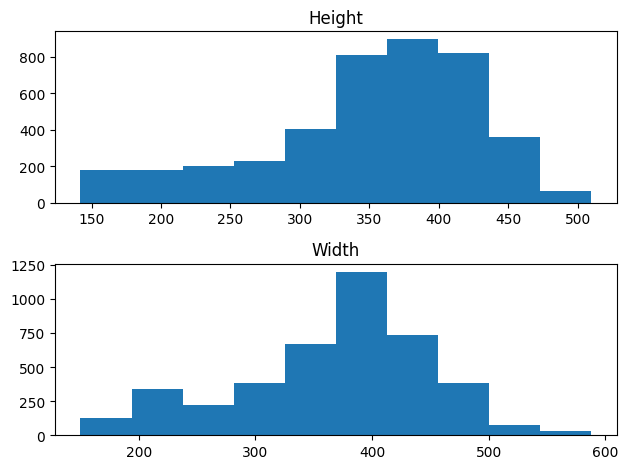

In [7]:
img_widths = np.array(img_widths)
img_heights = np.array(img_heights)
fig, axs = plt.subplots(2, 1)
axs[0].hist(img_heights)
axs[0].set_title("Height")
axs[1].hist(img_widths)
axs[1].set_title("Width")
fig.tight_layout()
plt.show()

In [8]:
print("Minimum ")
print("Height:", img_heights.min())
print("Width:", img_widths.min())
print("Mean ")
print("Height:", img_heights.mean())
print("Width:", img_widths.mean())
print("Median ")
print("Height:", np.median(img_heights))
print("Width:", np.median(img_widths))

Minimum 
Height: 142
Width: 150
Mean 
Height: 351.32160925078296
Width: 366.8349795230065
Median 
Height: 366.0
Width: 380.0


Most of the images are of height and width around 350 but there are a lot of images having height and width less than 200 but greater than 150, so to be conservative ill reshape all images to height and width 150. And since we are dealing with a simple classification model, it should work pretty well.

Since the dataset is imbalanced in nature, we have to deal with it. One way is to sample it in a balanced way.

In [9]:
train_data_temp = ImageFolder(root=os.path.join(dataset_path, "Apple vs Rotten Classification/train"))
train_labels = np.fromiter(map(lambda x: train_data_temp[x][1], range(0, len(train_data_temp))), dtype=np.int32)
del train_data_temp

We got all the labels of training data. Next we take the weight using that.

In [10]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([0, 1], dtype=int32), array([1670, 2354]))

In [11]:
weight = 1. / counts
weight

array([0.0005988 , 0.00042481])

In [12]:
train_labels_weight = np.where(train_labels==0, weight[0], weight[1])
train_labels_weight

array([0.0005988 , 0.0005988 , 0.0005988 , ..., 0.00042481, 0.00042481,
       0.00042481])

In [13]:
generator = torch.Generator(device='cpu')
generator.manual_seed(0)
sampler = WeightedRandomSampler(
    torch.from_numpy(train_labels_weight),
    len(train_labels_weight),
    replacement=True,
    generator=generator
)
sampler

Padding images so that resize won't distort the aspect ratio of apple images.

In [14]:
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return pad(img=image, padding=padding, fill=0, padding_mode='constant')

In [15]:
image_transforms_train = Compose([
    RandomRotation((0, 180), fill=0),
    SquarePad(),
    RandomHorizontalFlip(0.5),
    RandomVerticalFlip(0.5),
    Resize((150, 150)),
    ToTensor()
])

image_transforms_test = Compose([
    SquarePad(),
    Resize((150, 150)),
    ToTensor()
])

train_data = ImageFolder(
    root=os.path.join(dataset_path, "Apple vs Rotten Classification/train"),
    transform=image_transforms_train
)

val_data = ImageFolder(
    root=os.path.join(dataset_path, "Apple vs Rotten Classification/validation"),
    transform=image_transforms_test
)

test_data = ImageFolder(
    root=os.path.join(dataset_path, "Apple vs Rotten Classification/test"),
    transform=image_transforms_test
)

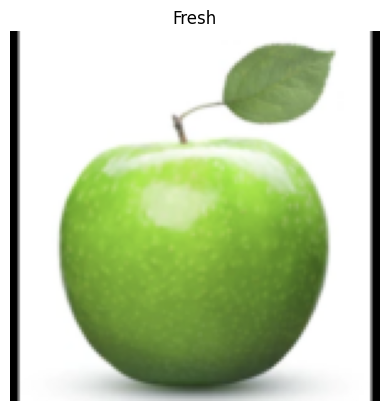

In [16]:
label_dict = {
    0: "Fresh",
    1: "Rotten"
}

img, label = val_data[np.random.randint(0, len(val_data))]
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.title(label_dict[label])
plt.axis(False)
plt.show()

In [17]:
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=sampler
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [18]:
val_data[0][0].shape

torch.Size([3, 150, 150])

In [19]:
class FreshOrRottenAppleModel(nn.Module):
    def __init__(self):
        super(FreshOrRottenAppleModel, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=(3, 3),
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=(3, 3),
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(3, 3),
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(3, 3),
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            ),
            nn.Flatten()
        )

        self.dense_block1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=128*7*7, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU()
        )

        self.dense_block2 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=512, out_features=256, bias=False),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU()
        )

        self.dense_block3 = nn.Sequential(
            nn.Linear(in_features=256, out_features=1)
        )

    def forward(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = self.conv_block3(out)
        out = self.conv_block4(out)
        out = self.dense_block1(out)
        out = self.dense_block2(out)
        out = self.dense_block3(out)
        return out

In [20]:
model = FreshOrRottenAppleModel()
model = model.to(device)

In [21]:
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             864
       BatchNorm2d-2         [-1, 32, 148, 148]              64
              ReLU-3         [-1, 32, 148, 148]               0
         MaxPool2d-4           [-1, 32, 74, 74]               0
            Conv2d-5           [-1, 64, 72, 72]          18,432
       BatchNorm2d-6           [-1, 64, 72, 72]             128
              ReLU-7           [-1, 64, 72, 72]               0
         MaxPool2d-8           [-1, 64, 36, 36]               0
            Conv2d-9          [-1, 128, 34, 34]          73,728
      BatchNorm2d-10          [-1, 128, 34, 34]             256
             ReLU-11          [-1, 128, 34, 34]               0
        MaxPool2d-12          [-1, 128, 17, 17]               0
           Conv2d-13          [-1, 128, 15, 15]         147,456
      BatchNorm2d-14          [-1, 128,


Total params: 3,453,121

Trainable params: 3,453,121

Non-trainable params: 0

Input size (MB): 0.26

Forward/backward pass size (MB): 13.93

Params size (MB): 13.17

Estimated Total Size (MB): 27.36


In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [23]:
def train(loader, model, loss_fn, optimizer):
    model.train()
    n_samples = 0
    print("Training ...")
    for batch_no, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.float().to(device)
        logits = model(images).squeeze()
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_samples += len(labels)
        if batch_no % 25 == 0:
            print(f"\t[{(batch_no+1)*len(images)}/{n_samples}] Loss: {loss.item():.4f}")
    print(f"\t[{n_samples}/{n_samples}] Loss: {loss.item():.3f}")

In [24]:
def test(loader, model, loss_fn):
    model.eval()
    n_correct = 0
    n_samples = 0
    cum_loss = 0
    print("Testing ...")
    with torch.inference_mode():
        for batch_no, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.float().to(device)
            logits = model(images).squeeze()
            loss = loss_fn(logits, labels)
            cum_loss += loss.item()
            pred = torch.round(torch.sigmoid(logits))
            n_correct += (pred == labels).type(torch.float).sum().item()
            n_samples += len(pred)
        avg_loss = (cum_loss/n_samples)
    print(f"\t[{n_samples}/{n_samples}] Loss: {avg_loss:.4f} | Accuracy: {(n_correct/n_samples)*100:.3f}%")
    return avg_loss

In [25]:
test(val_loader, model, loss_fn)

Testing ...
	[127/127] Loss: 0.0218 | Accuracy: 58.268%


0.021756950795181154

In [26]:
prev_loss = 9999
saved_state_dict = None
for e in range(n_epochs):
    print(f"Epoch {e+1}")
    train(train_loader, model, loss_fn, optimizer)
    loss = test(val_loader, model, loss_fn)
    if loss > prev_loss:
        break
    saved_state_dict = model.state_dict()
    prev_loss = loss
    print("-"*80)

Epoch 1
Training ...
	[32/32] Loss: 0.7321
	[832/832] Loss: 0.2356
	[1632/1632] Loss: 0.2456
	[2432/2432] Loss: 0.0830
	[3232/3232] Loss: 0.1924
	[3024/4024] Loss: 0.1839
	[4024/4024] Loss: 0.184
Testing ...
	[127/127] Loss: 0.0074 | Accuracy: 88.189%
--------------------------------------------------------------------------------
Epoch 2
Training ...
	[32/32] Loss: 0.4188
	[832/832] Loss: 0.0876
	[1632/1632] Loss: 0.1097
	[2432/2432] Loss: 0.0491
	[3232/3232] Loss: 0.0849
	[3024/4024] Loss: 0.0742
	[4024/4024] Loss: 0.074
Testing ...
	[127/127] Loss: 0.0071 | Accuracy: 88.976%
--------------------------------------------------------------------------------
Epoch 3
Training ...
	[32/32] Loss: 0.1120
	[832/832] Loss: 0.0273
	[1632/1632] Loss: 0.0386
	[2432/2432] Loss: 0.3870
	[3232/3232] Loss: 0.0663
	[3024/4024] Loss: 0.0285
	[4024/4024] Loss: 0.028
Testing ...
	[127/127] Loss: 0.0022 | Accuracy: 98.425%
--------------------------------------------------------------------------------
E

In [27]:
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

In [28]:
test(train_loader, model, loss_fn)

Testing ...
	[4024/4024] Loss: 0.0060 | Accuracy: 90.905%


0.006002153295405194

In [29]:
test(val_loader, model, loss_fn)

Testing ...
	[127/127] Loss: 0.0039 | Accuracy: 94.488%


0.0038965577919652145

In [30]:
test(test_loader, model, loss_fn)

Testing ...
	[880/880] Loss: 0.0048 | Accuracy: 93.409%


0.004796842093161434